<a href="https://colab.research.google.com/github/tomosantos/dio-ml-projects/blob/main/notebooks/Performance_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports

This block imports all necessary libraries and frameworks:

* **TensorFlow and Keras:** To load the MNIST dataset, build and train the model, and make predictions.
* **Matplotlib and Seaborn:** For visualizing data and results, such as the confusion matrix and ROC curves.
* **NumPy and Pandas:** For numerical and tabular data manipulation, critical for matrix operations and summarizing results.
* **Scikit-learn:** For metrics like ROC curves and AUC, which are not directly available in TensorFlow.

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, roc_curve, auc

## 2. Data Loading and Preprocessing

This block prepares the MNIST dataset for training and evaluation:

* **MNIST Dataset:** A benchmark dataset of handwritten digits, loaded directly via Keras utilities.
* **Reshaping:** Adds a channel dimension to the images since convolutional layers require this format.
* **Normalization:** Scales pixel values from `[0, 255]` to `[0, 1]` for faster training and better convergence.
* **Class Labels:** Defines a list of class labels (0-9) for metrics computation and visualizations.


In [2]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Reshape data to include the channel dimension (necessary for CNNs)
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [4]:
# Normalize images to range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
# Define the classes for MNIST
classes = list(range(10))

## 3. Model Definition

This block defines a Convolutional Neural Network (CNN):

* **Convolutional Layers:** Extract spatial features from the input images using filters.
* **Max-Pooling Layers:** Reduce the dimensionality of the feature maps, making computation more efficient.
* **Fully Connected Layers:** Integrate features from previous layers for final classification.
* **Softmax Output Layer:** Produces probabilities for each class, summing to 1. The model architecture is displayed with `model.summary()` for inspection.

In [6]:
# Build a Convolutional Neural Network (CNN)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Pooling layer

    layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Pooling layer

    layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer

    layers.Flatten(),  # Flatten output for Dense layers
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dense(10, activation='softmax')  # Output layer for classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Compilation and Training

This block prepares and trains the model:

* **Compilation:** Specifies:
  * **Optimizer:** Adam, for adaptive learning rates.
  * **Loss Function:** Sparse categorical crossentropy, suitable for multi-class classification.
  * **Metric:** Accuracy, to monitor performance.
* **Early Stopping:** Stops training if validation performance stops improving, preventing overfitting.
* **Training:** Runs the training process for up to 10 epochs, validating performance on unseen data (test set).

In [8]:
# Compile the model
model.compile(
    optimizer='adam',  # Use Adam optimizer
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Monitor accuracy during training
)

In [9]:
# Add a callback to stop early if validation accuracy stops improving
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
]

In [10]:
# Train the model
history = model.fit(
    train_images, train_labels,
    epochs=10,  # Train for 10 epochs
    validation_data=(test_images, test_labels),  # Use test set for validation
    callbacks=callbacks  # Include callbacks
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 33ms/step - accuracy: 0.8973 - loss: 0.3249 - val_accuracy: 0.9846 - val_loss: 0.0485
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 94s 39ms/step - accuracy: 0.9842 - loss: 0.0501 - val_accuracy: 0.9875 - val_loss: 0.0410
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 32ms/step - accuracy: 0.9889 - loss: 0.0349 - val_accuracy: 0.9871 - val_loss: 0.0382
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 34ms/step - accuracy: 0.9918 - loss: 0.0262 - val_accuracy: 0.9891 - val_loss: 0.0334
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - accuracy: 0.9937 - loss: 0.0184 - val_accuracy: 0.9899 - val_loss: 0.0327
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9962 - loss: 0.0133 - val_accuracy: 0.9898 - val_loss: 0.0352
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 102s 41ms/step - accuracy: 0.9961 - loss: 0.0126 - val_accuracy: 0.9892 - val_loss: 0.0376
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9961 

## 5. Prediction, Metrics and Confusion Matrix

This block evaluates the model's predictions:

* **Predictions:** Converts the model's output probabilities to class labels using `np.argmax()`.
* **Confusion Matrix:** Summarizes classification performance for each class, showing counts of correct and incorrect predictions.
* **Performance Breakdown:**
  * **True Positives (TP):** Correct predictions for a given class.
  * **False Positives (FP):** Incorrect predictions for a class.
  * **True Negatives (TN):** Correct non-predictions for a class.
  * **False Negatives (FN):** Missed predictions for a class.
* **Per-Class Metrics:** Show individual performance metrics for each class. These metrics are critical for understanding both general and class-specific performance.
  * The metrics worked on in this algorithm are: Accuracy, Precision, Recall (Sensitivity), Specificity, and F1 Score.
   1.  **Accuracy:** Accuracy measures the overall correctness of the model by evaluating the proportion of all correct predictions (both true positives and true negatives) out of the total number of predictions.

    2. **Precision:** Precision assesses the relevance of positive predictions by calculating the proportion of true positives out of all predicted positives, showing how reliable the positive classifications are.

    3. **Recall (Sensitivity):** Recall measures the ability of the model to identify all actual positive cases by computing the proportion of true positives out of all actual positives in the dataset.

    4. **Specificity:** Specificity evaluates the model's ability to correctly identify negative cases by calculating the proportion of true negatives out of all actual negatives, focusing on minimizing false positives.

    5. **F1 Score:** The F1 Score provides a balance between precision and recall by calculating their harmonic mean, making it particularly useful in cases with imbalanced datasets.
* **Aggregated Metrics:** Provide overall model performance.
* **Normalized Confusion Matrix:** Shows the proportion of predictions relative to the actual class size, aiding in comparative analysis.
* **Absolute Confusion Matrix:** Displays the raw counts of predictions for clarity on dataset size and error distribution. Both are visualized using Seaborn's heatmap for easy interpretation.


In [12]:
# Perform predictions on the test set
y_true = test_labels  # True labels
y_pred = np.argmax(model.predict(test_images), axis=1)  # Predicted labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [13]:
# Compute the confusion matrix
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

In [14]:
# Extract True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
tp = np.diag(con_mat)
fp = np.sum(con_mat, axis=0) - tp
fn = np.sum(con_mat, axis=1) - tp
tn = np.sum(con_mat) - (fp + fn + tp)

In [15]:
# Calculate metrics for each class
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)   # Sensitivity
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

In [22]:
# Print metrics
print("Accuracy per class:", np.round(accuracy, 4))
print("Precision per class:", np.round(precision, 4))
print("Recall (Sensitivity) per class:", np.round(recall, 4))
print("Specificity per class:", np.round(specificity, 4))
print("F1 Score per class:", np.round(f1_score, 4))


Accuracy per class: [0.9986 0.9992 0.9973 0.998  0.9985 0.9978 0.9983 0.9973 0.9976 0.9972]
Precision per class: [0.9939 0.9956 0.9763 0.9872 0.9959 0.9877 0.9968 0.9883 0.9917 0.9861]
Recall (Sensitivity) per class: [0.9918 0.9974 0.9981 0.9931 0.9888 0.9877 0.9854 0.9854 0.9836 0.9861]
Specificity per class: [0.9993 0.9994 0.9972 0.9986 0.9996 0.9988 0.9997 0.9987 0.9991 0.9984]
F1 Score per class: [0.9928 0.9965 0.9871 0.9901 0.9923 0.9877 0.9911 0.9868 0.9876 0.9861]


In [23]:
# Calculate aggregated metrics
total_tp = np.sum(tp)
total_fp = np.sum(fp)
total_fn = np.sum(fn)
total_tn = np.sum(tn)

# Aggregated Accuracy
agg_accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)

# Aggregated Precision
agg_precision = total_tp / (total_tp + total_fp)

# Aggregated Recall (Sensitivity)
agg_recall = total_tp / (total_tp + total_fn)

# Aggregated Specificity
agg_specificity = total_tn / (total_tn + total_fp)

# Aggregated F1 Score
agg_f1_score = 2 * (agg_precision * agg_recall) / (agg_precision + agg_recall)

In [25]:
# Print aggregated metrics
print("Accuracy:", round(agg_accuracy, 4))
print("Precision:", round(agg_precision, 4))
print("Recall (Sensitivity):", round(agg_recall, 4))
print("Specificity:", round(agg_specificity, 4))
print("F1 Score:", round(agg_f1_score, 4))

Accuracy: 0.998
Precision: 0.9899
Recall (Sensitivity): 0.9899
Specificity: 0.9989
F1 Score: 0.9899



The metrics indicate that the algorithm performs exceptionally well on the given classification task. An **accuracy** of 99.8% demonstrates that nearly all predictions, regardless of class, are correct. The **precision** and **recall** (sensitivity) values of 98.99% highlight a well-balanced model capable of minimizing false positives and false negatives. This balance is further corroborated by the **F1 Score** of 98.99%, which confirms that the model maintains strong predictive performance without disproportionately sacrificing precision or recall.

The **specificity** of 99.89% underscores the model's ability to correctly identify negative cases, making it highly reliable in tasks where distinguishing true negatives is critical. Overall, these metrics suggest that the algorithm is highly effective and robust, with minimal room for improvement. However, depending on the application, further evaluation on edge cases or underrepresented data subsets might be beneficial to ensure consistent generalization.

In [17]:
# Plot Confusion matrix (Normalized and Absolute)
# Convert confusion matrix to a DataFrame for visualization
con_mat_df_norm = pd.DataFrame(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], index=classes, columns=classes)
con_mat_df_abs = pd.DataFrame(con_mat, index=classes, columns=classes)

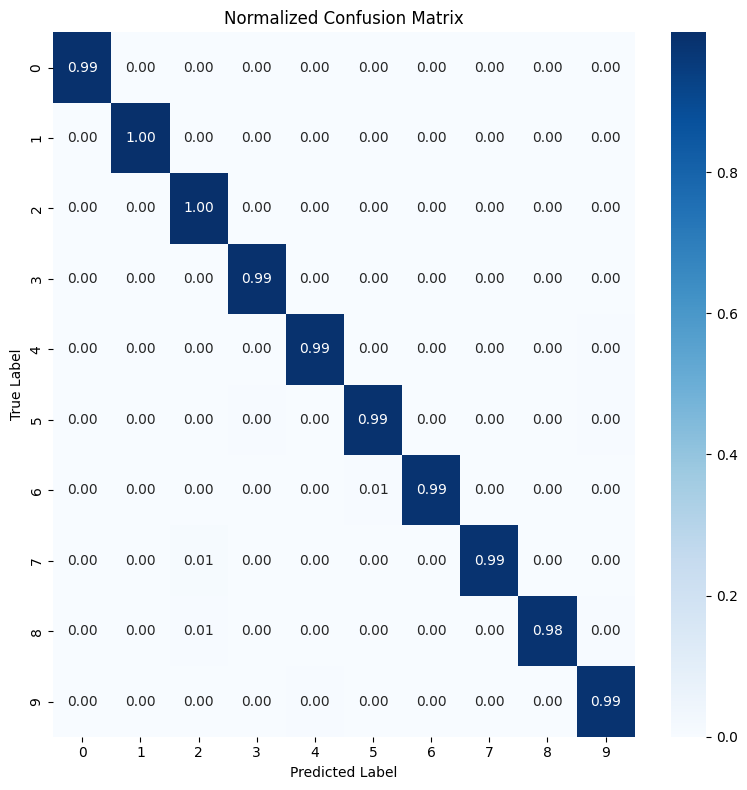

In [18]:
# Plot the normalized confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df_norm, annot=True, cmap=plt.cm.Blues, fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

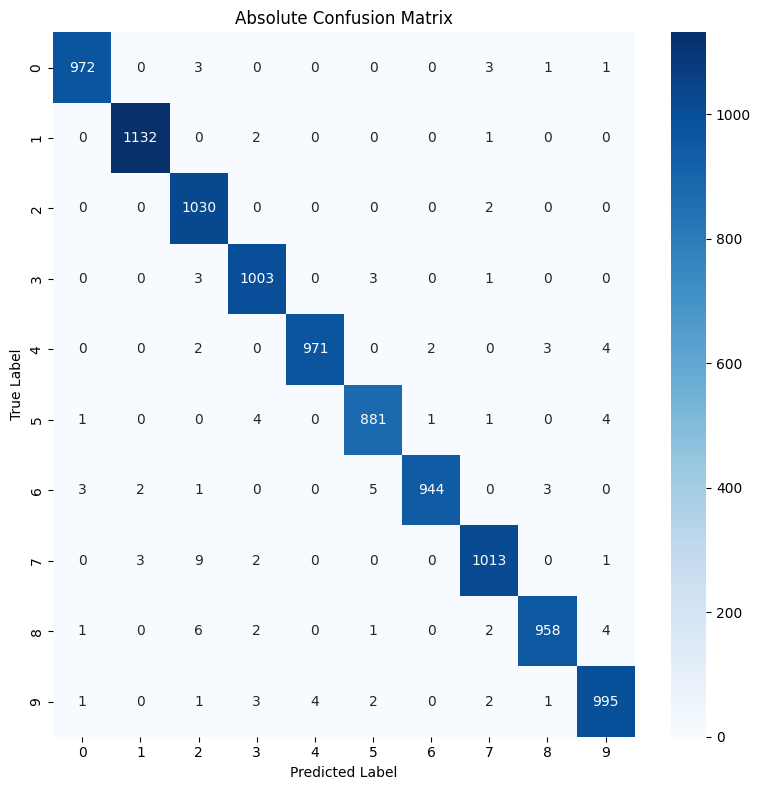

In [19]:
# Plot absolute confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df_abs, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title('Absolute Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 6. ROC Curve and AUC

This block evaluates the model using ROC curves and AUC:

* **ROC Curve:** Plots True Positive Rate (TPR) vs. False Positive Rate (FPR) for each class, illustrating the trade-off between sensitivity and specificity.
* **AUC:** Quantifies the overall performance of each class in the ROC space.
* **One-Hot Encoding:** Converts labels to a format required for multi-class ROC computation.
* **Visualization:** Combines ROC curves for all classes into a single plot, with AUC values in the legend.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


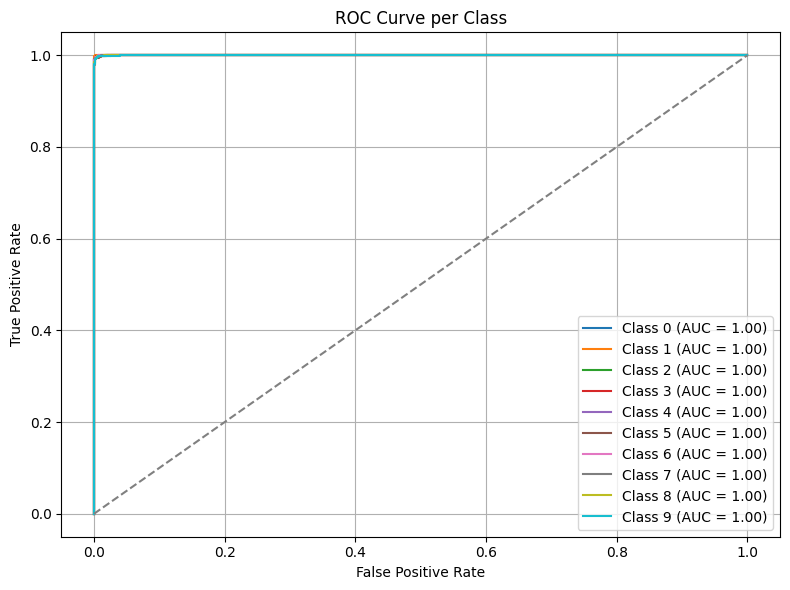

In [30]:
# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# One-hot encode the true labels for ROC calculation
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(classes))

y_pred_proba = model.predict(test_images)  # Probabilities for ROC calculation

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


The ROC curve displayed shows an exceptionally high performance for the classification model, with an AUC (Area Under the Curve) of 1.00 for all classes. This means that the model is capable of perfectly distinguishing between the positive and negative cases for every class without any misclassification. The TPR (True Positive Rate) reaches 1 while the FPR (False Positive Rate) remains at 0, indicating no false positives or negatives in the classification process.

Such a result suggests that the model is highly effective on this dataset, but it might also raise concerns about overfitting if the dataset used for evaluation is too similar to the training data. In a real-world scenario, this perfect performance should be verified on unseen, diverse datasets to confirm the model's ability to generalize beyond the provided test data.